In [1]:
import os
import joblib
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.applications import EfficientNetB0

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

from randomcutout_tf2_3 import RandomCutout

LOG MESSAGE

1. Version 3:
    * effnetB0
    * 10 epoch
    * image size 224
1. Version 4:
    * effnetB3
    * 12 epoch
    * image size 224
1. Version 5:
    * effnetB3
    * 12 epoch
    * image size 224
    
    * remove brightness tta

In [2]:
def set_seed(SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

In [3]:
CSV_DIR = '../input/cassava-leaf-disease-classification/train.csv'
IMG_DIR = '../input/cassava-leaf-disease-classification/train_images'
MODEL_DIR = '../input/cassava-efficientnetb3/ModelB3v1_'
METRICS_DIR = '../input/cassava-efficientnetb3/metrics.pkl'

DEBUG = False

SEED = 2021
CLASS = 5
BATCH_SIZE = 8
IMG_SIZE = 224
DROPOUT_RATE = 0.4
BUFFER_SIZE = 1024

INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)

AUTOTUNE = tf.data.experimental.AUTOTUNE
set_seed(SEED)

In [4]:
loss, val_loss, accuracy, val_accuracy, oof = joblib.load(METRICS_DIR)

df = pd.read_csv(CSV_DIR)
df['path'] = IMG_DIR + '/' + df.image_id
# df['label'] = df['label'].astype(str)

if DEBUG:
    df = df.head(25)
    oof = {0:[0,1,2,3,4],
           1:[5,6,7,8,9],
           2:[10,11,12,13,14],
           3:[15,16,17,18,19],
           4:[20,21,22,23,24]}
df.groupby('label')['path'].count()

label
0     1087
1     2189
2     2386
3    13158
4     2577
Name: path, dtype: int64

## Visualize loss and accuracy

In [5]:
def plot_metrics(name):
    matplotlib.style.use('default')
    epochs_range = range(12)
    line_colors = ['r', 'g', 'b', 'orange', 'm']
    plt.figure(figsize=(12, 4))
    if name =='accuracy':
        metrics = accuracy
        val_metrics = val_accuracy
    else:
        metrics = loss
        val_metrics = val_loss
    plt.title('{} and val_{}'.format(name, name))
    for k in loss.keys():
        plt.plot(epochs_range, metrics[k], marker='o', label='Fold{}'.format(k), color=line_colors[k], alpha=0.8)
        plt.plot(epochs_range, val_metrics[k], linestyle='--', marker='o', color=line_colors[k], alpha=0.8)
        plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        plt.ylabel(name)
        plt.xlabel('epoch')
        plt.legend()

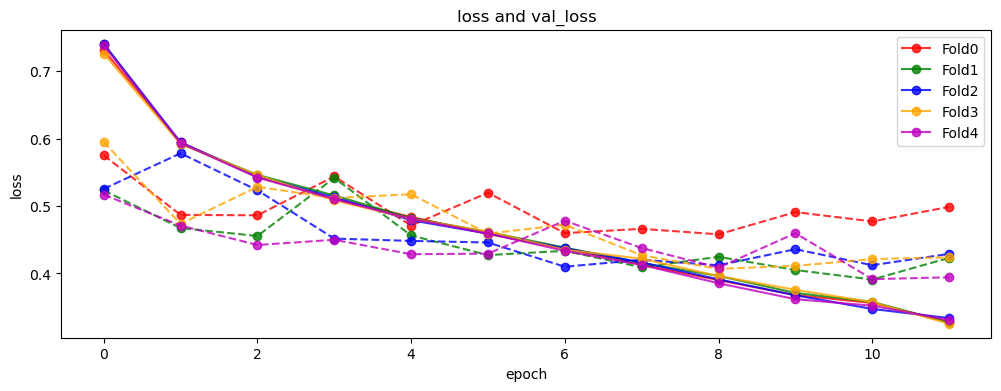

In [6]:
plot_metrics('loss')

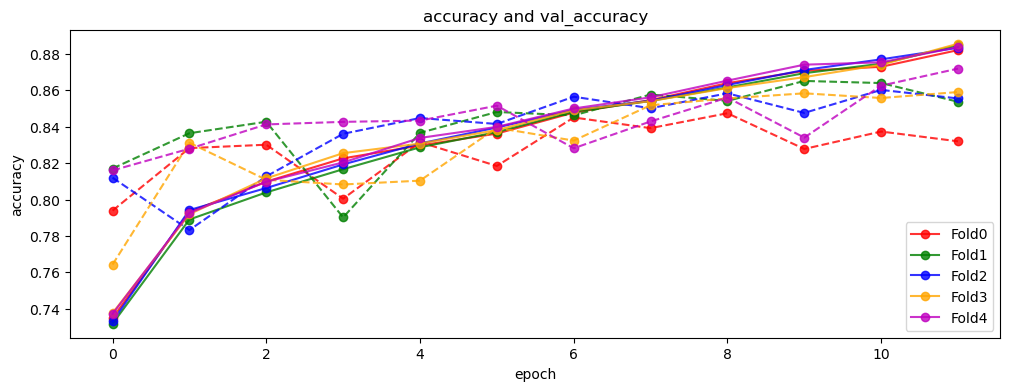

In [7]:
plot_metrics('accuracy')

## Predict OOF

In [8]:
def create_oof_dataset(X_oof):
    oof_dataset = tf.data.Dataset.from_tensor_slices((X_oof.path.values))
    return oof_dataset

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def tta_image(img):
#     img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
    return img


def create_oof_dataset_batch(X_oof, tta=False):
    oof_ds = create_oof_dataset(X_oof)
    oof_ds = oof_ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if tta:
        oof_ds = oof_ds.map(tta_image, num_parallel_calls=AUTOTUNE)
    oof_ds_batch = oof_ds.batch(BATCH_SIZE)
    
    return oof_ds_batch

def load_model(i):
    return(tf.keras.models.load_model(MODEL_DIR+str(i)+'.h5',
                                      custom_objects={'RandomCutout':RandomCutout}))

In [9]:
true = df.label.to_numpy()
pred = np.zeros(len(df))
for i in oof.keys():
    print('FOLD {}'.format(i))
    print('create model...')
    model = load_model(i)
    print('create dataset...')
    X_oof = df.iloc[oof[i]]
    print('predict...')
    oof_ds_batch = create_oof_dataset_batch(X_oof)
    _pred = model.predict(oof_ds_batch)
    pred[oof[i]] = np.argmax(_pred, axis=-1)

FOLD 0
create model...
create dataset...
predict...
FOLD 1
create model...
create dataset...
predict...
FOLD 2
create model...
create dataset...
predict...
FOLD 3
create model...
create dataset...
predict...
FOLD 4
create model...
create dataset...
predict...


In [10]:
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
#     sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1)
    ax = sns.heatmap(data, annot=True, cmap="Blues", cbar_kws={'label': 'Scale'}, fmt='d')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.show()

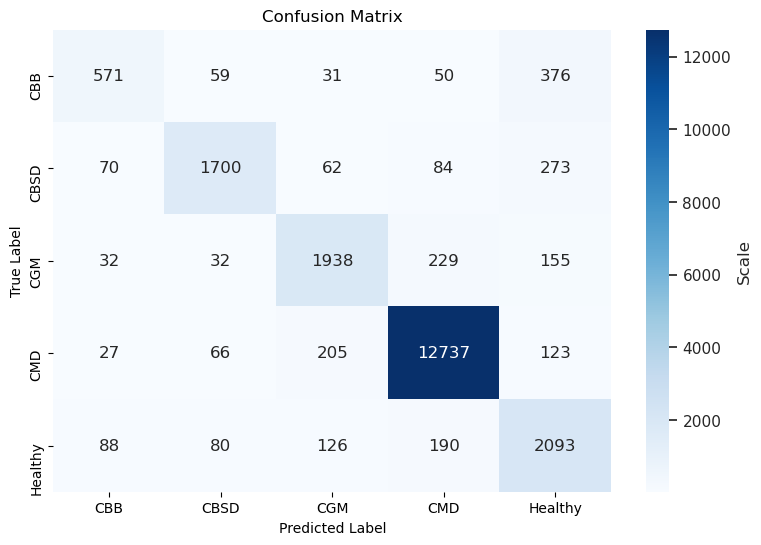

In [11]:
mtrx = metrics.confusion_matrix(true, pred)
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
plot_confusion_matrix(mtrx, class_names)

In [12]:
print(metrics.classification_report(true, pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.72      0.53      0.61      1087
           1       0.88      0.78      0.82      2189
           2       0.82      0.81      0.82      2386
           3       0.96      0.97      0.96     13158
           4       0.69      0.81      0.75      2577

    accuracy                           0.89     21397
   macro avg       0.81      0.78      0.79     21397
weighted avg       0.89      0.89      0.89     21397



## Predict OOF with TTA

In [13]:
true = df.label.to_numpy()
pred = np.zeros(len(df))
for i in oof.keys():
    print('FOLD {}'.format(i))
    print('create model...')
    model = load_model(i)
    print('create dataset...')
    X_oof = df.iloc[oof[i]]
    print('predict...')
    _tta_preds = []
    for k in range(5):
        oof_ds_batch = create_oof_dataset_batch(X_oof, tta=True)
        if k==0:
            oof_ds_batch = create_oof_dataset_batch(X_oof)
        _pred = model.predict(oof_ds_batch)
        _tta_preds.append(_pred)
    _pred = np.mean(_tta_preds, axis=0)
    pred[oof[i]] = np.argmax(_pred, axis=-1)

FOLD 0
create model...
create dataset...
predict...
FOLD 1
create model...
create dataset...
predict...
FOLD 2
create model...
create dataset...
predict...
FOLD 3
create model...
create dataset...
predict...
FOLD 4
create model...
create dataset...
predict...


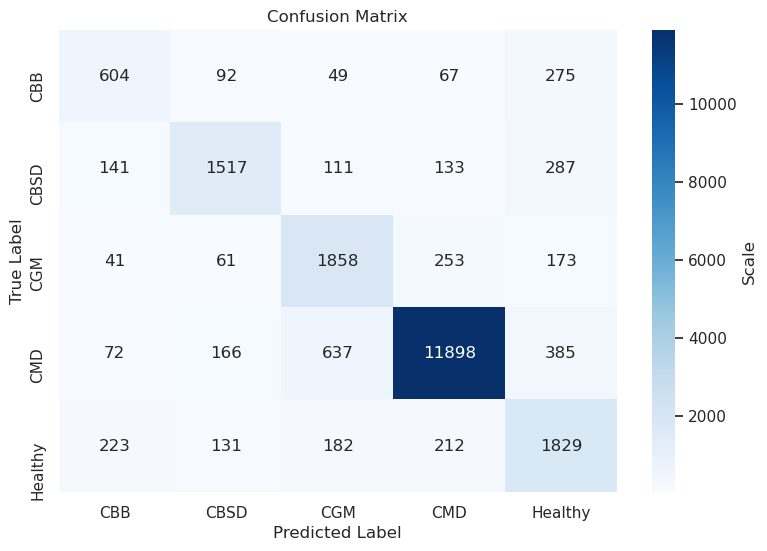

In [14]:
mtrx = metrics.confusion_matrix(true, pred)
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
plot_confusion_matrix(mtrx, class_names)

In [15]:
print(metrics.classification_report(true, pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1087
           1       0.77      0.69      0.73      2189
           2       0.65      0.78      0.71      2386
           3       0.95      0.90      0.93     13158
           4       0.62      0.71      0.66      2577

    accuracy                           0.83     21397
   macro avg       0.71      0.73      0.72     21397
weighted avg       0.84      0.83      0.83     21397

